<a href="https://colab.research.google.com/github/ME-UoP-ME421/Kalman-TSL/blob/main/mechanics/assignments/GP_Kalman_TSL_ME421_ControlSystems_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions

* This is a group assignment. Complete the activities in groups that were assigned for ME421 for the vibrations lab.

* Make a copy of this and save it in your group github group repository.

* Do all your work, EXCLUSIVELY, in that saved notebook. Your github commits will serve as a refelection of your individual contributions. It will constitute 25% of your final grade for the lab.

* Complete all the first 3 tasks by 21/06/2023 and demonstrate the work in the class on 21/06/2023.

* Complete Tasks#1 and Task#2 by 5:00PM on 14/06/2023

* Complete Tasks#3 and the Task#4 by 5:00PM on 21/06/2023 and demonstrate the work in the class on 21/06/2023.

* Complete Task#5 by 5:00PM on 28/06/2023.

#References

* https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/Mugas_Rigid_Body_Control.ipynb

* https://github.com/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/MaithriPalaDHS_RigidBodyPIDControl_IITB_18_03_2023.pdf

# Setting Up

## Importing Python Packages

In [142]:
#!pip install plotly Uncomment if you have not installed already

In [143]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math
from numpy import linalg
import sympy

from sympy import symbols
from sympy import *

import plotly.graph_objects as go
import plotly.express as px

## Python Rigid Body Class Definition

In [144]:
class mugas_rigid_body_functions:

  def __init__(self):
    self=[];

  def simulateDySystem(self, dynamicSystemModel, Tmax, dT, X0, sysPara, figTitle, xLabel, yLabel):
    t = np.linspace(0, Tmax, int(Tmax/dT+1))
    sol = odeint(dynamicSystemModel, X0, t, args=(sysPara,));
    self.soln=sol;
    fig = go.Figure()
    [nt,nS]=sol.shape;

    # Add traces
    for nn in range(nS):
      fig.add_trace(go.Scatter(x=t, y=sol[:,nn], mode='lines+markers', name='x'+str(nn+1)))
      fig.update_layout(title=figTitle, xaxis=dict(title=xLabel),yaxis=dict(title=yLabel))

    fig.show()
    return [t,sol,fig]

  def hatMatrix(self, X):
    return np.array([[0., -X[2], X[1]],[X[2], 0., -X[0]],[-X[1], X[0], 0.]])

  def qFromAxisAngles(self, theta, unitAxis):

     x=np.concatenate(([np.cos(theta/2)],np.sin(theta/2)*np.array(unitAxis)))
     print(x)
     return x

  def RfromQuaternions(self,q):
    q0=q[0]; w=q[1:];
    R=np.identity(3)+2*q0*self.hatMatrix(w)+2*self.hatMatrix(w) @ self.hatMatrix(w);
    return R

  def rotationMatrix2EulerAngles(self,R):
    if R[2,2] <1:
      if R[2,2] > -1:
        theta2=math.acos(R[2,2]);
        theta1=math.atan2(R[0,2],R[1,2]);
        theta3=math.atan2(R[2,0],-R[2,1]);
      else: #R[2,2]=-1 No Unique solution
        theta2=np.pi;
        theta1=-math.atan2(R[0,1],-R[0,0]);
        theta3=0;
    else: # R[2,2] = +1 No Unique solution
      theta2 = 0;
      theta1 = math.atan2(R[0,1],R[0,0]) ;
      theta3 = 0;
    return [np.pi-theta1,theta2,np.pi-theta3]


  def rotate_and_translate(self,objectVertices,R,b):
    #object vertices should be given as an numpy array of shape (3,n)
    #Ex - X=[0, 0, 2, 2, 0, 0, 2, 2], Y=[0, 2, 2, 0, 0, 2, 2, 0], Z=[0, 0, 0, 0, 1, 1, 1, 1]; objectVertices=[X,Y,Z]
    return np.array([[b[0],b[1],b[2]]]).T + R @ objectVertices


  def addOrthNormFrame(self, fig, o, R, axisRange, axisColor):
    e1=[1,0,0]; e2=[0,1,0]; e3=[0,0,1];
    b1=R @ e1; b2=R @ e2; b3=R @ e3;
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b1[0])], y=[str(o[1]),str(o[1]+b1[1])], z=[str(o[2]),str(o[2]+b1[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b2[0])], y=[str(o[1]),str(o[1]+b2[1])], z=[str(o[2]),str(o[2]+b2[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b3[0])], y=[str(o[1]),str(o[1]+b3[1])], z=[str(o[2]),str(o[2]+b3[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange[0], autorange=False), yaxis=dict(range=axisRange[1], autorange=False), zaxis=dict(range=axisRange[2], autorange=False), aspectratio=dict(x=1, y=1, z=1)))
    return fig

  def cube_vertices(self,cubeDimensions):
    l=cubeDimensions['l']; w=cubeDimensions['w']; h=cubeDimensions['h'];
    xp=cubeDimensions['xp']; yp=cubeDimensions['yp']; zp=cubeDimensions['zp'];
    #X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h]; XX=[X,Y,Z];
    X=[-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]; Y=[-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]; Z=[-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]; XX=[X,Y,Z];
    #X=[-l, -l, l, l, -l, -l, l, l]; Y=[-w, w, w, -w, -w, w, w, -w]; Z=[-h, -h, -h, -h, h, h, h, h]; XX=[X,Y,Z];
    return XX


  def animate_particle_motion(self, XX, axisRange, figTitle):
    xx=[jj[0] for jj in XX]
    yy=[jj[1] for jj in XX]
    zz=[jj[2] for jj in XX]

    fig = go.Figure(
        data=[go.Scatter3d(x=[xx[0]], y=[yy[0]],z=[zz[0]],
                        mode="markers",
                        marker=dict(color="red", size=10)),
              go.Scatter3d(x=xx, y=yy,z=zz, name='Path',
                        mode="lines",
                        line=dict(color="blue", width=2))],
        layout=go.Layout(
            scene = dict(
                        xaxis=dict(range=axisRange[0], autorange=False),
                        yaxis=dict(range=axisRange[1], autorange=False),
                        zaxis=dict(range=axisRange[2], autorange=False),
                        aspectratio=dict(x=1, y=1, z=1),
            ),
            title_text=figTitle, hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter3d(
                x=[p[0]],
                y=[p[1]],
                z=[p[2]],
                name='Particle',
                mode="markers",
                marker=dict(color="red", size=10))])

            for p in XX]
    )

    fig.show()
    return fig

  def animated_cube_flat_shading(self, cubeVertices, figTitle):
    fig = go.Figure(
        frames=[go.Frame(data=[
          go.Mesh3d(
            # 8 vertices of a cube
            x=xx[0][0],
            y=xx[0][1],
            z=xx[0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)]) for xx in cubeVertices])

    fig.add_trace(go.Mesh3d(
            # 8 vertices of a cube
            x=cubeVertices[0][0][0],
            y=cubeVertices[0][0][1],
            z=cubeVertices[0][0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)
        )
    duration=10;
    fig.update_layout(
          title=figTitle,
          width=600,
          height=600,
          scene=dict(
                      xaxis=dict(range=[-5., 5.], autorange=False),
                      yaxis=dict(range=[-5., 5.], autorange=False),
                      zaxis=dict(range=[-5., 5.], autorange=False),
                      aspectratio=dict(x=1, y=1, z=1),
                      ),
          updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                            )])])
    len(fig.frames)
    fig.show()
    return fig


  def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
    XX=self.cube_vertices(cubeDimensions);

    #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
    Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);

    ICR=ICs[0][0];
    XX0=ICR @ XX;

    rotatedVertices=[[XX0]]
    for X in Xs:
      #print(X[0])
      R=X[0][0];
      o=X[0][1];
      XXi=self.rotate_and_translate(XX,R,o);
      XX0=XXi;
      rotatedVertices+=[[XX0]];
    return rotatedVertices


  def eulers_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      [taue,fe]=externalForceModel(self, parameters,X);
      [taua,fa]=actuator(self, parameters, t, X,taue,fe);

      dspi=taue+taua;
      dp=fe+fa;
      dXc=controller_dynamics(self, t,X,taue,fe,parameters)

      if linalg.norm(omega)>=0.0001:
        nomega=omega/linalg.norm(omega);
        thetaomegat=dt*linalg.norm(omega);
      else:
        nomega=np.array([0,0,0]);
        thetaomegat=0;
      qomegat=np.concatenate(([np.cos(thetaomegat/2)],np.sin(thetaomegat/2)*nomega));
      R=self.RfromQuaternions(qomegat) @ R;
      o=o+dt*doto;
      spi=spi+dt*dspi;
      p=p+dt*dp;
      doto=p/M;
      omega=R @ invII @ R.T @ spi;
      Xc=Xc+dt*dXc;
      X=[[R,o],omega,doto, Xc];
      Xout+=[X]

    return Xout

  def runga_kutta_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    X=ICs;
    Xout=[X];
    for t in timeSteps:
      Y1=self.rk4_function(0.5*dt, X, t, X, parameters);
      Y2=self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters);
      Y3=self.rk4_function(dt, X, t+0.5*dt, Y2, parameters);

      [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, t, X);
      [thetaomega2,nomega2,doto2,dp2,dspi2,dXc2]=self.rigid_body_system(parameters, t+0.5*dt, Y1);
      [thetaomega3,nomega3,doto3,dp3,dspi3,dXc3]=self.rigid_body_system(parameters, t+0.5*dt, Y2);
      [thetaomega4,nomega4,doto4,dp4,dspi4,dXc4]=self.rigid_body_system(parameters, t+dt, Y3);

      omegak=(dt/6.0)*(thetaomega1*nomega1+2*thetaomega2*nomega2+2*thetaomega3*nomega3+thetaomega4*nomega4)
      if linalg.norm(omegak)>=0.0001:
        nomegak=omegak/linalg.norm(omegak);
        thetaomegak=linalg.norm(omegak);
      else:
        nomegak=np.array([0,0,0]);
        thetaomegak=0;
      qomegak=np.concatenate(([np.cos(thetaomegak/2)],np.sin(thetaomegak/2)*nomegak));
      Rk=self.RfromQuaternions(qomegak) @ X[0][0];

      dotok=(1./6.0)*(doto1+2*doto2+2*doto3+doto4);
      dpk=(1./6.0)*(dp1+2*dp2+2*dp3+dp4);
      dspik=(1./6.0)*(dspi1+2*dspi2+2*dspi3+dspi4);
      dXck=(1./6.0)*(dXc1+2*dXc2+2*dXc3+dXc4);

      ok=X[0][1]+dt*dotok;
      pk=X[2]+dt*dpk;
      spik=X[0][0]@II@X[0][0].T@X[1]+dt*dspik;
      Xck=X[3]+dt*dXck;
      omegak=Rk @ linalg.inv(II) @ Rk.T @ spik;
      X=[[Rk,ok],omegak,pk,Xck];
      Xout+=[X]
    return Xout

  def rk4_function(self, dtk, X, tk, Xk, parameters):
    M=parameters['M']; II=parameters['II'];
    [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, tk, Xk)
    qomega1=np.concatenate(([np.cos(dtk*thetaomega1/2)],np.sin(dtk*thetaomega1/2)*nomega1));
    R1=self.RfromQuaternions(qomega1)@X[0][0];
    p1=X[2]+dtk*dp1;
    spi1=X[0][0]@II@X[0][0].T@X[1]+dtk*dspi1; omega1=R1@linalg.inv(parameters['II'])@R1.T@spi1;
    X1=[[R1, X[0][1]+dtk*doto1],omega1,p1, X[3]+dtk*dXc1]
    return X1

  def rigid_body_system(self, parameters, t, X):
    barX=parameters['CM']; M=parameters['M'];
    R=X[0][0]; omega=X[1]; p=X[2];

    [taue,fe]=externalForceModel(self, parameters,X);
    [taua,fa]=actuator(self, parameters, t, X,taue,fe);

    doto=p/M;
    dp=fe+fa;
    dspi=taue+taua;
    dXc=controller_dynamics(self, t,X,taue,fe,parameters);
    if linalg.norm(omega)>=0.0001:
      nomega=omega/linalg.norm(omega);
      thetaomega=linalg.norm(omega);
    else:
      nomega=np.array([0,0,0]);
      thetaomega=0;
    return [thetaomega,nomega,doto,dp,dspi,dXc]

In [145]:
rigid_body_functions=mugas_rigid_body_functions

In [146]:
def LinearSystemModel(X, t, A):
  dXdt=A @ X;
  return dXdt

In [147]:
def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=qq.RfromQuaternions(qOmegart);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI)
  fu=-fe+np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  #print(eR)
  return dXc

In [148]:
rigid_body_functions=mugas_rigid_body_functions()

#Task#1

Conside a rigid body moving in space. Let $\mathbf{b}$ be a body fixed frame with the origin coinciding with that of the center of mass of the body, $M$ be the tatal mass of the body, $\mathbb{I}$ be the inertia tensor of the body with respect to the body frame $\mathbf{b}$, $f^e$ be the resultant total external interactions acting on the particles of the body, and $\tau^e$ be the total resultant of the moments of the external interactions about the center of mass of the body.

Show that a general rigid body is descibed by the following simple equations in an inertial frame $\mathbf{e}$ where the moments are taken about the center of mass of the rigid body.

\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}
where
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}
Here we have split the force and control moments into unmanipulatable and manipulatable (control) part. The manipulatable (control) part will be denoted by a superscript $u$.

### Answer for task 1

#### Equation 1

\begin{align}
\dot{o}&=\frac{1}{M}p
\end{align}

From Newton's second law,
\begin{equation}
\frac{d\mathbf{p}}{dt} = \sum \mathbf{F}
\end{equation}


where,

 * $\frac{d\mathbf{p}}{dt}$ - the derivative of the momentum, $\mathbf{p}$ with respect to time

 * $\sum \mathbf{F}$  - sum of all external forces acting on the body

Also for a rigid body we can say,

\begin{equation}
\mathbf{p} = \sum m_i \mathbf{v}_i,
\end{equation}

where,

 * $m_i$ is the mass of the $i$ th particle, and $\mathbf{v}_i$ is its velocity.

For the weighted average of all particle locations, with the weights determined by the masses of the particles, may be used to determine the center of mass of a rigid body. Therefore we ca say,
\begin{equation}
\mathbf{o} = \frac{1}{M} \sum m_i \mathbf{r}_i  ---->(1)
\end{equation}

where

* $\mathbf{o}$ is the position vector of the center of mass
* $\mathbf{r}_i$ is the position vector of the $i$ th particle
* $M$ is the total mass of the body ; ( $M = \sum m_i$ )

differentiate equation (1)  respect to time,
\begin{align}
\dot{\mathbf{o}} & =\frac{d}{dt} \left( \frac{1}{M} \sum m_i \mathbf{r}_i \right)\\
  & =\frac{1}{M} \sum m_i \frac{d\mathbf{r}_i}{dt}\\
  & =\frac{1}{M} \sum m_i \mathbf{v}_i  \hspace{1cm} ; where \hspace{1cm} $\frac{d\mathbf{r}_i}{dt} = \mathbf{v}_i\\
  & =\frac{1}{M} \mathbf{p}
\end{align}

Threfore we have,

\begin{align}
\dot{o}&=\frac{1}{M}p
\end{align}


#### Equation 2

\begin{align}
\dot{R}&=\widehat{\omega}R
\end{align}

The rotation matrix, $R$, represents the orientation of the body in 3D space.

The angular velocity vector, $\boldsymbol{\omega}$, describes the rate of rotation.

The derivative of the rotation matrix, $\dot{R}$, represents the change in orientation over time.

The relationship between $\dot{R}$ and $\boldsymbol{\omega}$ is given by
\begin{equation}
 \dot{R} = R * \widehat{\boldsymbol{\omega}}
\end{equation}
$ \widehat{\boldsymbol{\omega}}$ is a skew-symmetric matrix derived from $\boldsymbol{\omega}$.

Multiplying $R$ by $ \widehat{\boldsymbol{\omega}}$ yields the time derivative of the rotation matrix.

Consider the frame in which $\boldsymbol{\omega}$ is expressed when using the equation.

\begin{equation}
\dot{R} = \widehat{\boldsymbol{\omega}} R
\end{equation}

Additionaly,

Considering a point $P$ fixed in the body frame,

We can say its position vector in the inertial frame,
\begin{equation}
\mathbf{r} = R \mathbf{r}_0
\end{equation}
where,

* $\mathbf{r}_0$ is the position vector of $P$ in the body-fixed frame.

differenciate by time,

\begin{align}
\dot{\mathbf{r}} &= \frac{d}{dt} (R \mathbf{r}_0)\\
&= \dot{R} \mathbf{r}_0
\end{align}

Considering
\begin{equation}
\boldsymbol{\omega} = \dot{\mathbf{r}},
\end{equation}

We can say,
\begin{equation}
\boldsymbol{\omega} \times \mathbf{r} = (\dot{R} \mathbf{r}_0) \times (R \mathbf{r}_0)
\end{equation}

Since $\mathbf{r}_0$ is an arbitrary vector we can say,
\begin{align}
\boldsymbol{\omega} \times \mathbf{r} &= \dot{R} R \mathbf{r}_0\\
\boldsymbol{\omega} \times (R \mathbf{r}_0) &= \dot{R} R \mathbf{r}_0
\end{align}

Multiply both sides by $R^{-1}$
\begin{equation}
\boldsymbol{\omega} \times \mathbf{r}_0 = \dot{R} R
\end{equation}

Hence, we can state that the cross product of $\boldsymbol{\omega}$ and $\mathbf{r}_0$, denoted as $\boldsymbol{\omega} \times \mathbf{r}_0$, can be represented by the skew-symmetric matrix $\widehat{\boldsymbol{\omega}}$.


\begin{equation}
\boldsymbol{\omega} \times \mathbf{r}_0 = \widehat{\boldsymbol{\omega}} \mathbf{r}_0
\end{equation}

Substituting this into the previous equation,

\begin{equation}
\widehat{\boldsymbol{\omega}} \mathbf{r}_0 = \dot{R} R
\end{equation}

This equation connects  $\widehat{\boldsymbol{\omega}}$ to the  $\dot{R}$. Thus, the equation that characterizes the rotational motion of a rigid body, $\dot{R} = \widehat{\boldsymbol{\omega}} R$, has been obtained.

#### Equation 3

\begin{align}
\dot{p}&=f^e+f^u
\end{align}

#### Equation 4

\begin{align}
\dot{\pi}&=\tau^e+\tau^u
\end{align}

**Linear Momentum:**
Newton's second law states that the rate of change of linear momentum is equal to the net force acting on an object. Considering a rigid body, we can express this as:
\begin{equation}
\dot{p} = \sum f,
\end{equation}

where $\dot{p}$ represents the time derivative of linear momentum, and $\sum f$ denotes the sum of all forces acting on the body.

**External and Unmanipulatable Forces:**
As forces act on a body, moments can also arise from both external and internal sources. To distinguish between them, we divide the total moment into two components: the resultant external moment $\tau^e$ and the unmanipulatable moment $\tau^u$.

The resultant external moment $\tau^e$ represents the overall moment exerted on the body by external sources, such as torque applied by external forces or moments resulting from interactions with the surroundings. These moments cannot be directly controlled or manipulated by the body.


The unmanipulatable force $f^u$ corresponds to forces that originate from internal sources (such as control forces) or external sources that the body can control or manipulate. These forces are commonly employed to achieve intended motions or regulate the behavior of the body.


**Angular Momentum:**
Just as linear momentum is conserved when there are no external forces, angular momentum is also conserved. However, when external moments act on a rigid body, the angular momentum undergoes changes. This can be expressed as:

\begin{equation}
\dot{\pi} = \sum \tau,
\end{equation}

Here, $\dot{\pi}$ represents the time derivative of angular momentum, and $\sum \tau$ indicates the sum of all moments acting on the body.


**External and Unmanipulatable Moments:**
Both external and internal sources can contribute to the moments acting on a body, similar to forces. To differentiate between them, we divide the total moment into two components: the resultant external moment $\tau^e$ and the unmanipulatable moment $\tau^u$.

The resultant external moment $\tau^e$ represents the overall moment exerted on the body by external sources, such as torque applied by external forces or moments arising from interactions with the environment. These moments are beyond the direct control or manipulation of the body itself.


The unmanipulatable moment $\tau^u$ denotes moments that originate from internal sources (such as control moments) or external sources that the body can control or manipulate. These moments are commonly utilized to attain desired rotations or regulate the orientation of the body.

**Combining External and Unmanipulatable Parts:**
To consider both the external and unmanipulatable forces and moments, we combine the corresponding parts as follows:

\begin{equation}
\dot{p} = f^e + f^u, \quad \dot{\pi} = \tau^e + \tau^u.
\end{equation}

These equations represent the change in linear momentum and angular momentum of a rigid body, where the changes are determined by the combined effects of the resultant external interactions ($f^e$ and $\tau^e$) and the unmanipulatable interactions ($f^u$ and $\tau^u$).


#Task#2

Simulate the motion of a quadrotor UAV without resorting any parameterization of $SO(3)$ such as Euler angles or quaternions.

##Answer-Part2

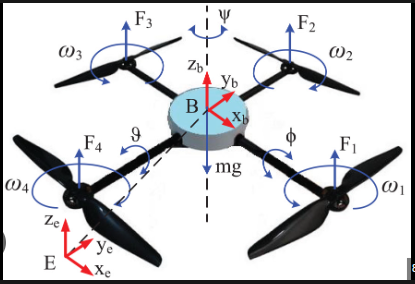

Conside a rigid body moving in space. Let $\mathbf{b}$ be a body fixed frame with the origin coinciding with that of the center of mass of the quadrotor UAV , $M$ be the tatal mass of the  quadrotor UAV, $\mathbb{I}$ be the inertia tensor of the quadrotor UAV with respect to the body frame $\mathbf{b}$, $f^e$ and $f^u$  be the resultant total external Controllable and uncontrollable interactions acting on the particles of the body, and $\tau^e$  and  $\tau^u$ be the total resultant of the controllble uncontrollble moments of the external interactions about the center of mass of the quadrotor UAV.



* Motion of the quadrotor UAV can be fullly discribed by Rotation and Translation.


* Let $o$ is the center of mass of the quadrotor UAV R is the Rotation Matrix that describe the rotation of the body fixed frame $b$ (quadrotor UAV).

* Then motion of the quadrotor UAV is fully dicribe by using $R$ and $o$  these are can be determined by following simple equationsfor  general rigid body is descibed  in an inertial frame  e  where the moments are taken about the center of mass of the rigid body.


\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}
where
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}






.

In a quadrotor UAV, the primary method of controlling its motion is through adjusting the angular velocities of its rotors. By varying the speed of each rotor, the quadrotor can generate different amounts of thrust and torque, enabling it to maneuver and change its orientation in three-dimensional space. The relationship between the angular velocities of the rotors and the resulting forces and torques is can be found as follows.

Let,

* $\omega_1,\omega_2,\omega_3,\omega_4$ are the anguler velocities of four rotors (As shown in above figure)
* $f_e ,F_e$ -Uncontrolable resultant external forces acting on the quadrotor UAV in frame $e$ and $b$
* $f_u ,F_u$ -Controlable resultant external forces acting on the quadrotor UAV in frame $e$ and $b$

* $t_e ,T_e -$- Uncontrolble resultant external torques  acting on the quadrotor UAV in frame $e$ and $b$
* $t_u ,T_u -$- Controlble resultant external torques  acting on the quadrotor UAV in frame $e$ and $b$

 For Our case applying neutons equtions ,

**For $f_e$**

* There is only one Uncontrlable external forces  due to mass of the quadrotor UAV.
* Weight is acting on the quadrotor UAV at $e_z$
direction.

\begin{align}
f_e = \begin{bmatrix} 0 & 0& -Mg \end{bmatrix}
\end{align}


**For $t_e$**

* There is only one Uncontrlable external forces  due to mass of the quadrotor UAV therefore no uncontrolable external torques acting on the quadrotor UAV


\begin{align}
t_e = \begin{bmatrix} 0 & 0& 0 \end{bmatrix}
\end{align}

**For $f_u$**

* There are four external controllable external forces acting on the quadrotor UAV. these are due thrust forces of four rotors.

* Resutant thrust force is given by,


\begin{align}
F = c_1(w_1^2+w_2^2+w_3^2+w_4^2)
\end{align}

* This is acting on $b_z$ direction then

\begin{align}
F_u = F \begin{bmatrix} 0 \\ 0\\ 1\end{bmatrix} \\
F_u = c_1(w_1^2+w_2^2+w_3^2+w_4^2) \begin{bmatrix} 0 \\ 0\\ 1\end{bmatrix} \\
F_u =  \begin{bmatrix} 0 \\ 0\\ c_1(w_1^2+w_2^2+w_3^2+w_4^2)\end{bmatrix}
\end{align}


\begin{align}
f_u = RF_u
\end{align}


**For $t_u$**

* Uncontrolavle external torques due to e four external controllable external forces acting on the quadrotor UAV.

* By taking moments about three axis of body fixed frame ,


\begin{align}
T_{b1} = l *c_1*w_2^2-l *c_1*w_4^2 \\
T_{b2} = -l *c_1*w_1^2+l *c_1*w_3^2\\
T_{b3} = -c_2*w_1^2+c_2*w_2^2+ c_2*w_3^2+c_2*w_4^2
\end{align}
* Then

\begin{align}
T_u = \begin{bmatrix} 0 & lc_1 &0& -lc_1 \\ -lc_1 &0&lc_1 &0 \\ -c_d&c_d &-c_d& c_d\end{bmatrix} \begin{bmatrix}w_1^2\\w_2^2\\w_3^2 \\w_4^2\end{bmatrix}
\end{align}

* Then

\begin{align}
t_u = RT_u
\end{align}

Then by Solving above rigid body equation $R$ and $o$ can be find


####Simulation-Analysis

* For Simulation Quadrotor UAV can be  assumed as the following model

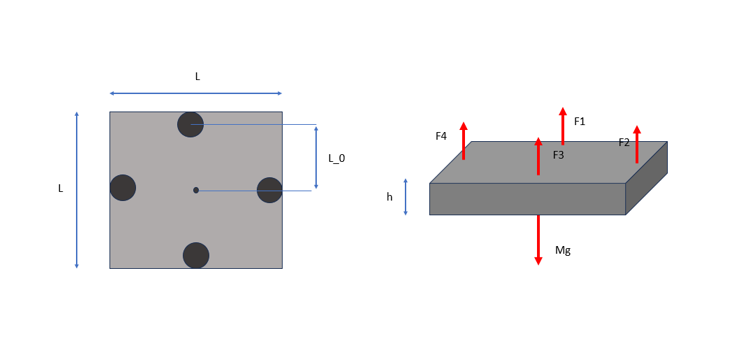

* Inertia tensor is give by ,


\begin{align}
I = \begin{bmatrix} \frac{L^2+L^2}{12}&0&0 \\0&\frac{L^2+H^2}{12}&0 \\ 0&0&\frac{L^2+H^2}{12}\end{bmatrix}
\end{align}

**Initial conditions**

* Lets take Initial rotation of quadrotor UAV( $b$ frame) with resepect to frame $e$

\begin{align}
R = \begin{bmatrix} 1&0&0 \\0&1&0 \\ 0&0&1\end{bmatrix}
\end{align}


* Initial Displacement of the quadrotor UAV( $b$ frame) with resepect to frame $e$

\begin{align}
o = \begin{bmatrix} 2\\ 2\\ 0\end{bmatrix}
\end{align}

####Simulation Code

#####Functions

In [ ]:
Anguar_veocities=[0,0,0,0]

#Function1-External Uncontralble Torques and forces
def externalForceModel_Uncontrollabe(qq,parameters,X):
  M=parameters['M']; II=parameters['II']; g=parameters['g']; CM=parameters['CM'];
  R=X[0][0]; omega=X[1]; spi=R@ II@ R.T @ omega

  #External Uncontralble Torques
  #taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1])-0*spi;
  taue=np.array([0,0,0]);

  #External Uncontralble forces
  fe=np.array([0,0.,-M*g]);
  return [taue,fe]


#Function2-External contralble Torques and forces
def externalForceModel_Controllabe(qq,parameters, t, X, taue,fe):

  R=X[0][0];
  l1=1 #Distane between center and a rotor
  cd=0.005 # Rotor Foces cofficient 1
  cl=0.01  # Rotor Foces cofficient 1

  #Angular veocities
  #angularveocity_1(t)
  w1=Anguar_veocities[0]
  w2=Anguar_veocities[1]
  w3=Anguar_veocities[2]
  w4=Anguar_veocities[3]


  #External Contralble Torques
  ts=np.array([[0,l1*cl,0,-l1*cl],[-l1*cl,0,l1*cl,0],[-cd,cd,-cd,cd]])
  ip_omega=np.array([[w1*w1],[w2*w2],[w3*w3],[w4*w4]])
  Tauu=ts@ip_omega
  tauu1=(R@Tauu)
  tauu=np.array([tauu1[0][0],tauu1[0][0],tauu1[0][0]])

  #External Contralble Torques
  Fu_1=cl*(w1*w1+w2*w2+w3*w3+w4*w4)
  gamma=np.array([[0],[0],[1]])
  Fu=Fu_1*gamma
  fu1 =(R@Fu)
  fu=np.array([fu1[0][0],fu1[1][0],fu1[2][0]])

  return [tauu,fu]


def angularveocity_1(t):
  if (t<3):
   Anguar_veocities[0]=8
   Anguar_veocities[1]=8
   Anguar_veocities[2]=8
   Anguar_veocities[3]=8

  elif(3<= t<= 3.1):
     Anguar_veocities[0]=6
     Anguar_veocities[1]=6
     Anguar_veocities[2]=0
     Anguar_veocities[3]=0

  else:
     Anguar_veocities[0]=5
     Anguar_veocities[1]=5
     Anguar_veocities[2]=6
     Anguar_veocities[3]=6
  return




In [ ]:
#Function3-Simulation of the  quadrotor_UAV
def quadrotor_UAV_simulation(w1,w2,w3,w4):
  Anguar_veocities[0]=w1
  Anguar_veocities[1]=w2
  Anguar_veocities[2]=w3
  Anguar_veocities[3]=w4

  #Initial conditions
  #Cube dimensions
  cubeDimensions={'l':2.,'w':2,'h':0.5,'xp':1.,'yp':1.,'zp':0.25,};
  #Other parameters
  parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['l']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':1, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
  #Initial Rotation
  R_initial=np.array([[1,0,0],[0,1,0],[0,0,1]])
  #initial Displacement
  o_initial=np.array([20.,20.,0.]);
  #initial anguler velocity
  omega_initial=np.array([0.,0.,0.]);

  #Other conditons
  ICq=rigid_body_functions.qFromAxisAngles(0,np.array([1,0,0]));
  ICp=np.array([0.,0.,0.]);
  ICXC=np.array([0,0,0]);
  ICs=[[R_initial,o_initial],omega_initial,ICp,ICXC]

  #Simulation the cube
  dynamics_model=rigid_body_functions.simulating_a_cube(0.01, 15., cubeDimensions, parameters,ICs)
  fig1=rigid_body_functions.animated_cube_flat_shading(dynamics_model,'Quadrotor UAV')




#####Run

In [ ]:
quadrotor_UAV_simulation(10,10,10,10)

#Task#3

Deerive a PID controller for the attitude control of a quadrorotor and use simulations to demibstrate the very large region of stability of the controller

Here are few example our own implementations of this controller.

* https://youtu.be/6E9WDQNVSYA
* https://youtu.be/uUKxXImRMOA
* https://youtu.be/zq05N8m_9SA
* https://youtu.be/J5dThZGZN2g
* https://youtu.be/J5MMp6Be3tU
* https://youtu.be/6ZQgE1FI6Wc

##Answer



###Simulation Code

In [123]:
ref=np.array([0,0,0])

def  quadrotor_attitue_PID(I_theta1,I_theta2,I_theta3,R_theta1,R_theta2,R_theta3):
  #Initial conditions
  #Cube dimensions
  cubeDimensions={'l':2.,'w':2,'h':0.5,'xp':1.,'yp':1.,'zp':0.25,};
  #Other parameters
  parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['l']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':9.8, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
  #Initial Rotation

  R_initial=R_from_h(np.pi/2,0,0)  #(I_theta1,I_theta2,I_theta3) #rigid_body_functions.RfromQuaternions(ICq); #np.array([[1,0,0],[0,1,0],[0,0,1]])

  #initial Displacement
  o_initial=np.array([0.,0.,0.]);
  #initial anguler velocity
  omega_initial=np.array([0.,0.,0.]);

   #Other conditons

  ICp=np.array([0.,0.,0.]);
  ICXC=np.array([0,0,0]);
  ICs=[[R_initial,o_initial],omega_initial,ICp,ICXC]


  #Reffrence Condition (R)
  ref[0]=R_theta1
  ref[1]=R_theta2
  ref[2]=R_theta3

  aa4=rigid_body_functions.simulating_a_cube(0.05, 20., cubeDimensions, parameters,ICs)
  fig1=rigid_body_functions.animated_cube_flat_shading(aa4,'Fully Actuated Cube Pivoted at a Vertex')
  return 0

def externalForceModel_Uncontrollabe(qq,parameters,X):
  #Heavy Top Object
  R=X[0][0];
  M=parameters['M']; g=parameters['g']; CM=parameters['CM'];
  fe=np.array([0,0,0]);
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1]);
  return [taue,fe]

def externalForceModel_Controllabe(qq,parameters, t, X, taue,fe):
  Uc=controller(qq, parameters, t, X, taue,fe);
  tauu=Uc[0]; fu=Uc[1]
  return [tauu,fu]



def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=R_from_h(0,0,0)#R_from_h(ref[0],ref[1],ref[2]);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI)
  fu=-fe+np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  #print(eR)
  return dXc

def R_from_h (t1,t2,t3):
  R1=np.array([[1,0,0],[0,np.cos(t1),-np.sin(t1)],[0,np.sin(t1),np.cos(t1)]])
  R2=np.array([[np.cos(t2),0,np.sin(t2)],[0,1,0],[-np.sin(t2),0,np.cos(t2)]])
  R3=np.array([[np.cos(t3),-np.sin(t3),0],[np.sin(t3),np.cos(t3),0],[0,0,1]])
  R_1=R1@R2
  R=R_1@R3
  return R






In [ ]:
quadrotor_attitue_PID(np.pi/2,0,0,0,0,0)

###Simulation code2

In [149]:
def externalForceModel_Uncontrollabe(qq,parameters,X):
  #Heavy Top Object
  R=X[0][0];
  M=parameters['M']; g=parameters['g']; CM=parameters['CM'];
  fe=np.array([0,0,0]);
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1]);
  return [taue,fe]

def externalForceModel_Controllabe(qq,parameters, t, X, taue,fe):
  Uc=controller(qq, parameters, t, X, taue,fe);
  tauu=Uc[0]; fu=Uc[1]
  return [tauu,fu]


def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=np.array([[1,0,0],[0,1,0],[0,0,1]])#qq.RfromQuaternions(qOmegart);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI)
  fu=-fe+np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  #print(eR)
  return dXc

def R_from_h (t1,t2,t3):
  R1=np.array([[1,0,0],[0,np.cos(t1),-np.sin(t1)],[0,np.sin(t1),np.cos(t1)]])
  R2=np.array([[np.cos(t2),0,np.sin(t2)],[0,1,0],[-np.sin(t2),0,np.cos(t2)]])
  R3=np.array([[np.cos(t3),-np.sin(t3),0],[np.sin(t3),np.cos(t3),0],[0,0,1]])
  R_1=R1@R2
  R=R_1@R3
  return R

#Initial conditions
#Cube dimensions
cubeDimensions={'l':2.,'w':2,'h':0.5,'xp':1.,'yp':1.,'zp':0.25,};
#Other parameters
parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['l']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':9.8, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
#Initial Rotation
ICq=rigid_body_functions.qFromAxisAngles(np.pi/3,np.array([1,1,1]));
R_initial=R_from_h(np.pi/2,0,0) #rigid_body_functions.RfromQuaternions(ICq); #np.array([[1,0,0],[0,1,0],[0,0,1]])

#initial Displacement
o_initial=np.array([0.,0.,0.]);
#initial anguler velocity
omega_initial=np.array([0.,0.,0.]);

#Other conditons

ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[R_initial,o_initial],omega_initial,ICp,ICXC]

[0.8660254 0.5       0.5       0.5      ]


In [150]:
aa4=rigid_body_functions.simulating_a_cube(0.05, 20., cubeDimensions, parameters,ICs)
fig1=rigid_body_functions.animated_cube_flat_shading(aa4,'Fully Actuated Cube Pivoted at a Vertex')

#Task#4

Derive a specialization of the controller develoed in Task#3 for the problem of stabilzing an inverted pendulum on a cart.

###Simulation Code

In [ ]:
ref=np.array([0,0,0])

def  quadrotor_attitue_PID(I_theta1,I_theta2,I_theta3,R_theta1,R_theta2,R_theta3):
  #Initial conditions
  #Cube dimensions
  cubeDimensions={'l':1,'w':1,'h':3,'xp':0.5,'yp':0.5,'zp':0,};
  #Other parameters
  parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['l']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':9.8, 'M':0.1, 'II':np.array([[((cubeDimensions['l'])**2+(cubeDimensions['w'])**2)/12,0.,0.],[0.,((cubeDimensions['w'])**2+(cubeDimensions['h'])**2)/12,0.],[0.,0.,((cubeDimensions['l'])**2+(cubeDimensions['h'])**2)/12]])};
  #Initial Rotation

  R_initial=R_from_h(I_theta1,I_theta2,I_theta3) #rigid_body_functions.RfromQuaternions(ICq); #np.array([[1,0,0],[0,1,0],[0,0,1]])

  #initial Displacement
  o_initial=np.array([0.,0.,0.]);
  #initial anguler velocity
  omega_initial=np.array([0.,0.,0.]);

   #Other conditons

  ICp=np.array([0.,0.,0.]);
  ICXC=np.array([0,0,0]);
  ICs=[[R_initial,o_initial],omega_initial,ICp,ICXC]


  #Reffrence Condition (R)
  ref[0]=R_theta1
  ref[1]=R_theta2
  ref[2]=R_theta3

  aa4=rigid_body_functions.simulating_a_cube(0.1, 50, cubeDimensions, parameters,ICs)
  fig1=rigid_body_functions.animated_cube_flat_shading(aa4,'Fully Actuated Cube Pivoted at a Vertex')


def externalForceModel_Uncontrollabe(qq,parameters,X):
  #Heavy Top Object
  R=X[0][0];
  M=parameters['M']; g=parameters['g']; CM=parameters['CM'];
  fe=np.array([0,0,0]);
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1]);
  return [taue,fe]

def externalForceModel_Controllabe(qq,parameters, t, X, taue,fe):
  Uc=controller(qq, parameters, t, X, taue,fe);
  tauu=Uc[0]; fu=Uc[1]
  return [tauu,fu]



def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=R_from_h(ref[0],ref[1],ref[2]);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI)
  fu=-fe+np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  #print(eR)
  return dXc

def R_from_h (t1,t2,t3):
  R1=np.array([[1,0,0],[0,np.cos(t1),-np.sin(t1)],[0,np.sin(t1),np.cos(t1)]])
  R2=np.array([[np.cos(t2),0,np.sin(t2)],[0,1,0],[-np.sin(t2),0,np.cos(t2)]])
  R3=np.array([[np.cos(t3),-np.sin(t3),0],[np.sin(t3),np.cos(t3),0],[0,0,1]])
  R_1=R1@R2
  R=R_1@R3
  return R






In [ ]:
quadrotor_attitue_PID(np.pi/3,0,0,0,0,0)

#Task#5

 Experimentally verify the stability properties of the controller derived in Task#5 using the experimental setup available in the applied mechanics lab.